### Final Propensity matching results

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython


In [2]:
%reload_ext Cython

In [3]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [4]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )
import data_process
from tqdm import tqdm
from path import col_seq_can_all, col_seq_can 
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load pre matching data

In [5]:
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA ./Pre_Matching_DATA --recursive;

In [6]:
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/tempHybridSelectionMoreData/random.p ./Pre_Matching_DATA/random.p;

In [7]:
pp_str = 'Pre_Matching_DATA/'

treated2 = pd.read_pickle(pp_str+'treated2.p')
controls = pd.read_pickle(pp_str+'controls.p')
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle(pp_str+'random.p')

In [8]:
treated2.shape

In [9]:
controls.shape

In [10]:
pmpm.shape

# Transform data into latent space

In [11]:
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')

model = models.load_model("../../../temp/TF_Latent_Model_m6_Canary_stacked", compile=False)

/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type

In [54]:
onset = "CC_DIABETES"
cols_to_keep = ["PERS_ID", "MYR", 'AGE_AT_MIDMONTH', 'MBR_GNDR', onset]

In [13]:
latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

In [14]:
%%time
#transform data of sick and healthy treated, and controls
tr2 = data_process.transform_features_with_NN(model, treated2[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
cntrls = data_process.transform_features_with_NN(model, controls[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
rndm = data_process.transform_features_with_NN(model, random_controls[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)

CPU times: user 1min 39s, sys: 28.5 s, total: 2min 8s
Wall time: 1min 13s


### Pick Columns for matching

In [34]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

all_columns2 = list(set(all_columns1)-set(['IP_BIN6', 'ER_BIN6', 'LOB']))

In [16]:
%%time

#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']
match_on = latent_cols
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':None,
                        'hier_range':None, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': False, 'exact_match_dict': None}
matched0, matched_data0 = matched_population(tr2.copy(), 
                                           cntrls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:328522 before they were:354792


1604it [25:38,  1.04it/s]

CPU times: user 40min 28s, sys: 26min 43s, total: 1h 7min 12s
Wall time: 25min 42s


####  In addition to the previously created matched groups create a random group

In [19]:
Path('./tempHierALL').mkdir(exist_ok = True)
p = './tempHierALL/'
matched_data0.to_pickle(p+'match0_l.p')
tr2.to_pickle(p+'treated0_l.p')

In [26]:
matched_data0_o = controls[controls.set_index(["PERS_ID", "MYR"]).index.isin(matched_data0.set_index(["PERS_ID", "MYR"]).index)].sort_values(by=["PERS_ID", "MYR"])

In [28]:
matched_data0_o.to_pickle(p+"match0_o.p")

In [30]:
rndm.to_pickle(p+"random_l.p")

In [22]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [23]:
from utils import statistics_first_month, p_val, stat_matrices 

### List containing all numerical columns

In [24]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

### Stats First Month(Treated and Matched Controls)

In [31]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated2, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_data0_o, all_columns, return_array = True)

CPU times: user 3.63 s, sys: 36 ms, total: 3.66 s
Wall time: 3.66 s


### Stats First Month(General Pop and Random)

In [32]:
%%time
pmpm_desc = statistics_first_month(pmpm2, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

CPU times: user 2min 26s, sys: 7.43 s, total: 2min 33s
Wall time: 2min 33s


In [35]:
%%time
conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)

CPU times: user 26.7 ms, sys: 1.84 ms, total: 28.5 ms
Wall time: 27.3 ms


## Statistics on matching date

In [36]:
conds_first.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.206           50.184   0.061  0.952             44.311   47.606
ALLOW_AMT        693.750          681.162   0.217  0.828           1065.926  648.803
MBR_GNDR           0.206            0.211  -0.473  0.636              0.443    0.431
CC_TOBACCO         0.061            0.128  -7.588  0.000              0.074    0.098
CC_PRESSURE        0.001            0.003  -1.155  0.248              0.007    0.007
CC_OBESITY         0.456            0.298  12.401  0.000              0.109    0.228
CC_HYPERTENSION    0.325            0.259   5.372  0.000              0.208    0.249
CC_HYPOTHYROID     0.095            0.081   1.824  0.068              0.047    0.063
CC_DX_CNT          2.706            2.547   2.523  0.012              1.824    2.344
ACUTE2             0.039            0.049  -1.589  0.112              0.063    0.052
ACUTE6             0.112            0.148  -2.821  0.005              0.063    0.153
IP_BIN6            0.028            0.042  -2.073  0.038              0.021    0.047
ER_BIN6            0.089            0.115  -2.354  0.019              0.047    0.116
LOB                0.952            0.824  13.039  0.000              0.756    0.788

In [37]:
full_first

Treated                    Matched Controls                       Test-TC               General Population                         Test-TG                    Random                       Test-TR              
                       mean          std count             mean          std count     t-stat          pval               mean          std   count     t-stat          pval        mean          std count     t-stat          pval
AGE_AT_MIDMONTH   50.205736    12.733903  1604        50.184436    12.837650  7710   0.060542  9.517254e-01          44.310976    20.053585  356446  11.762030  6.207968e-32   47.606399    19.811819  7876   5.046484  4.583703e-07
ALLOW_AMT        693.750000  2216.211182  1604       681.161997  2086.071956  7710   0.217486  8.278342e-01        1065.926022  6933.418650  356446  -2.149328  3.160904e-02  648.802692  3166.090228  7876   0.542150  5.877276e-01
MBR_GNDR           0.205736     0.404364  1604         0.211025     0.408062  7710  -0.473023  6.362077e-01           0.442749     0.496712  356446 -19.081951  3.914644e-81    0.431056     0.495255  7876 -17.097185  1.439342e-64
CC_TOBACCO         0.061097     0.239583  1604         0.127626     0.333695  7710  -7.588142  3.556931e-14           0.074202     0.262100  356446  -1.998705  4.564109e-02    0.098400     0.297874  7876  -4.714462  2.458070e-06
CC_PRESSURE        0.001247     0.035300  1604         0.002853     0.053345  7710  -1.154686  2.482487e-01           0.007390     0.085645  356446  -2.871419  4.086576e-03    0.006602     0.080991  7876  -2.598386  9.380812e-03
CC_OBESITY         0.456359     0.498247  1604         0.298184     0.457490  7710  12.401352  4.854844e-35           0.108841     0.311440  356446  44.434357  0.000000e+00    0.228035     0.419592  7876  19.209513  1.041149e-80
CC_HYPERTENSION    0.324813     0.468451  1604         0.259403     0.438336  7710   5.372136  7.968654e-08           0.207717     0.405674  356446  11.525694  9.915163e-31    0.249365     0.432673  7876   6.274847  3.652926e-10
CC_HYPOTHYROID     0.094763     0.292979  1604         0.080934     0.272751  7710   1.823550  6.825211e-02           0.047300     0.212281  356446   8.916454  4.836392e-19    0.063484     0.243847  7876   4.516264  6.370084e-06
CC_DX_CNT          2.706359     2.227360  1604         2.547471     2.308543  7710   2.522978  1.165308e-02           1.824419     2.412274  356446  14.614465  2.345498e-48    2.343702     2.439688  7876   5.504457  3.799632e-08
ACUTE2             0.038653     0.208377  1604         0.048508     0.229450  7710  -1.589222  1.120442e-01           0.063258     0.243426  356446  -4.041413  5.314111e-05    0.051549     0.237733  7876  -2.020160  4.339483e-02
ACUTE6             0.111596     0.412699  1604         0.148119     0.483057  7710  -2.821444  4.790917e-03           0.063258     0.243426  356446   7.901966  2.753095e-15    0.153377     0.475791  7876  -3.274968  1.060534e-03
IP_BIN6            0.028055     0.199403  1604         0.041894     0.251463  7710  -2.072639  3.823333e-02           0.020587     0.141996  356446   2.097153  3.598074e-02    0.046851     0.263725  7876  -2.701482  6.915408e-03
ER_BIN6            0.088529     0.359723  1604         0.114786     0.415583  7710  -2.353617  1.861241e-02           0.047286     0.212251  356446   7.732311  1.058846e-14    0.116176     0.402957  7876  -2.548765  1.082613e-02
LOB                0.951995     0.213843  1604         0.823995     0.380849  7710  13.039256  1.589411e-38           0.755775     0.429627  356446  18.281467  1.257397e-74    0.787836     0.408866  7876  15.649481  1.606802e-54

### Statistics Over all dates (treated, controls)

In [38]:
%%time
tr_desc0A = treated2[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_data0_o[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

CPU times: user 734 ms, sys: 971 µs, total: 735 ms
Wall time: 734 ms


### Statistics Over all dates (general population, Random)

In [39]:
%%time
pmpm_descA = pmpm2[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

CPU times: user 29 s, sys: 2.37 s, total: 31.3 s
Wall time: 31.3 s


In [40]:
%%time
conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)

CPU times: user 28.2 ms, sys: 0 ns, total: 28.2 ms
Wall time: 26.9 ms


In [41]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.837           51.054  -2.528  0.011             50.379   50.236
ALLOW_AMT        782.435          806.871  -0.853  0.393            857.856  706.609
MBR_GNDR           0.189            0.195  -2.198  0.028              0.433    0.429
CC_TOBACCO         0.063            0.127 -29.293  0.000              0.102    0.100
CC_PRESSURE        0.002            0.004  -4.557  0.000              0.013    0.008
CC_OBESITY         0.505            0.339  50.429  0.000              0.255    0.286
CC_HYPERTENSION    0.325            0.281  14.204  0.000              0.329    0.300
CC_HYPOTHYROID     0.095            0.092   1.778  0.075              0.078    0.075
CC_DX_CNT          2.918            2.833   5.135  0.000              2.955    2.759
ACUTE2             0.032            0.047  -9.916  0.000              0.060    0.050
ACUTE6             0.100            0.143 -13.974  0.000              0.168    0.150
IP_BIN6            0.025            0.042 -10.835  0.000              0.055    0.049
ER_BIN6            0.079            0.109 -11.200  0.000              0.122    0.111
LOB                0.953            0.824  52.826  0.000              0.802    0.803

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [42]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [43]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [44]:
base_path =  './results/hier_matching_ALL/'
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [45]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

In [46]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


#### remove %%capture to see output

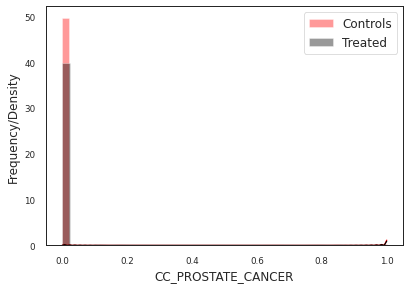

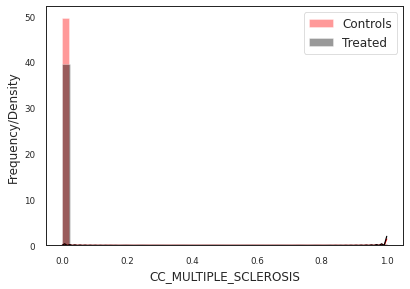

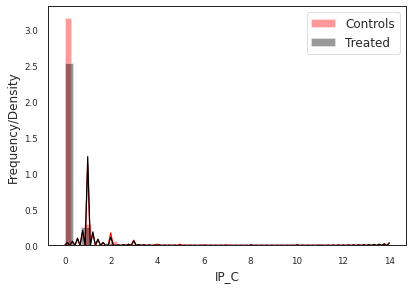

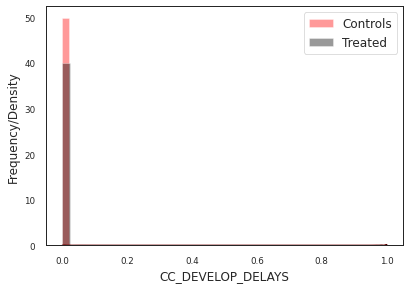

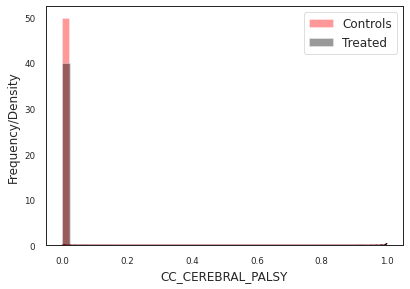

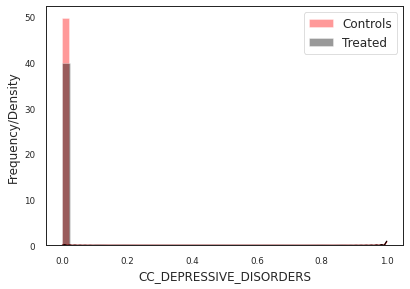

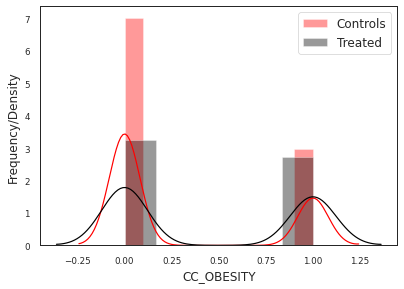

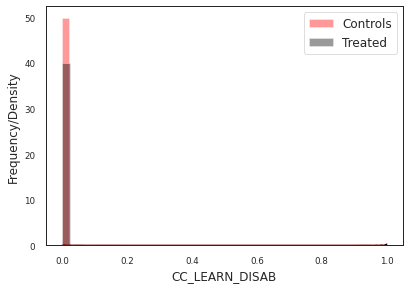

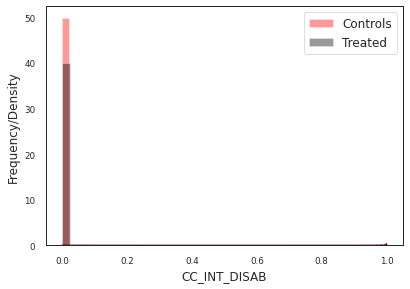

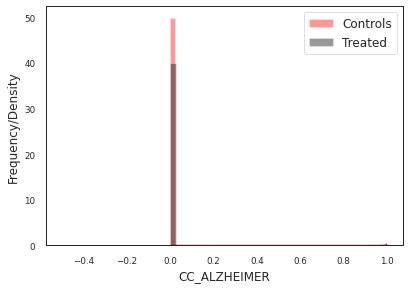

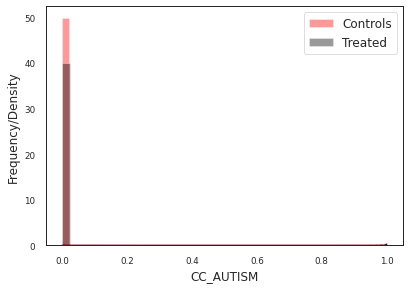

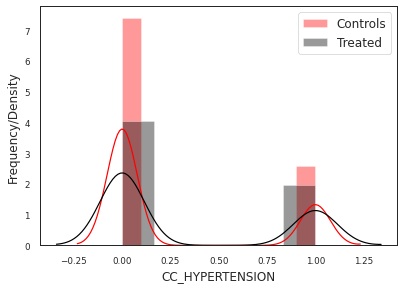

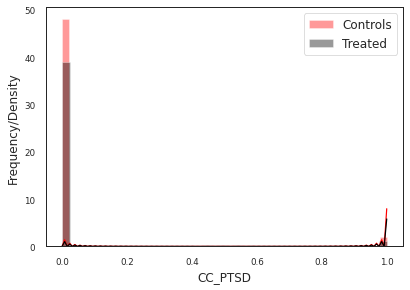

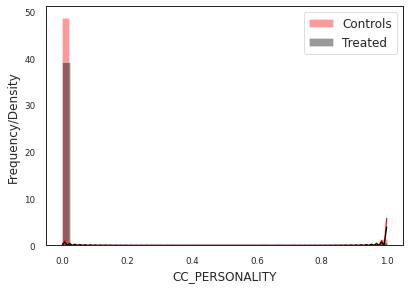

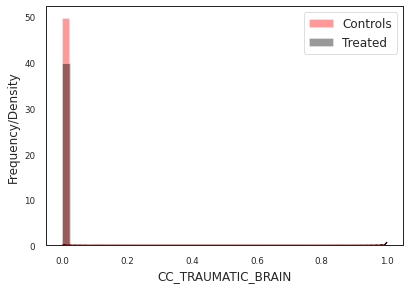

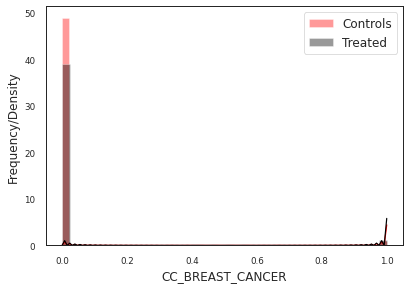

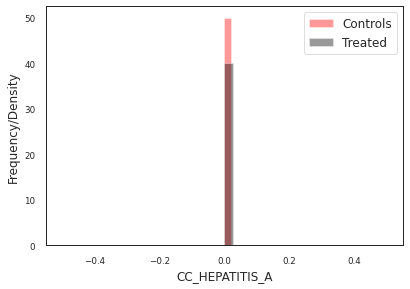

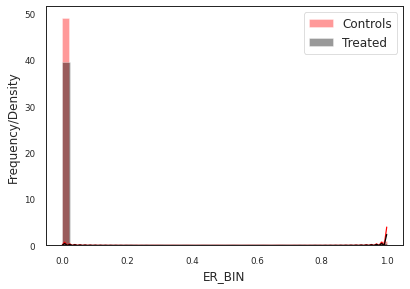

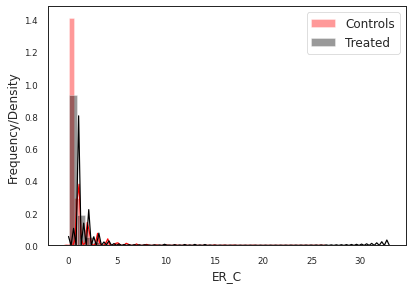

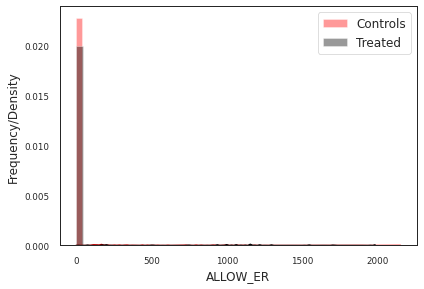

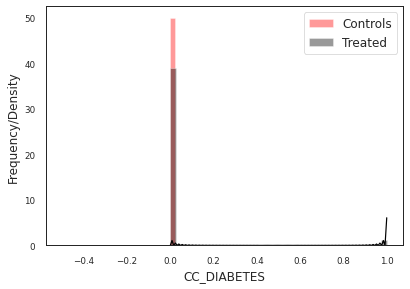

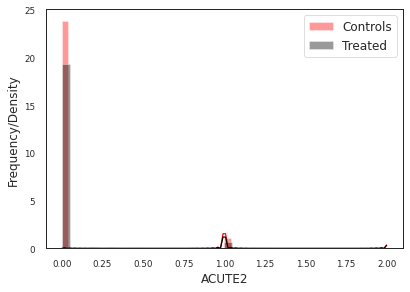

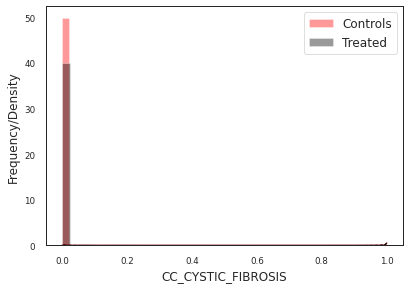

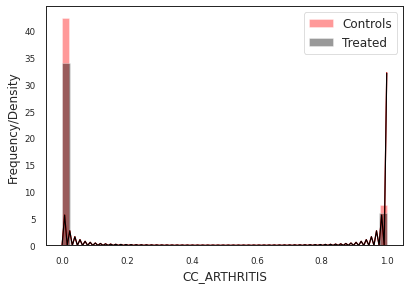

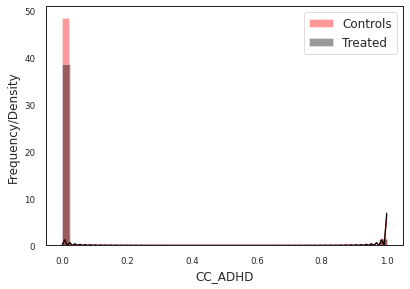

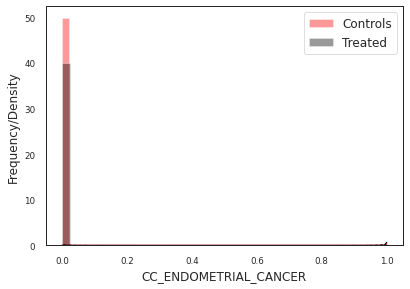

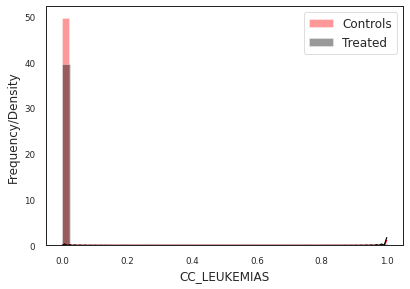

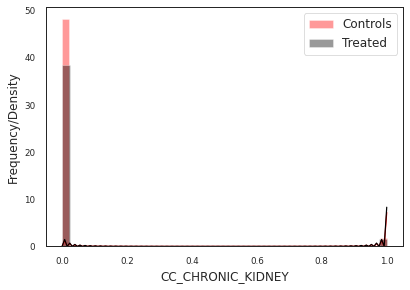

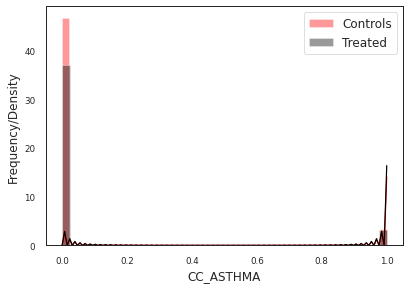

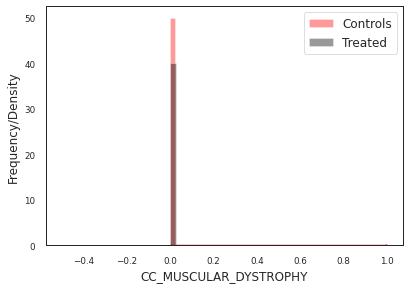

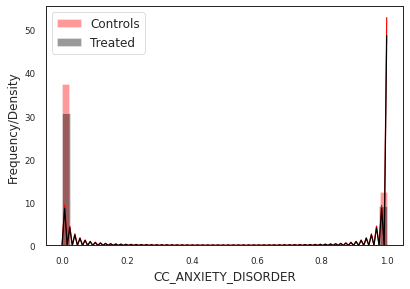

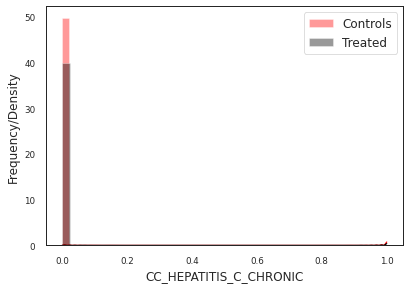

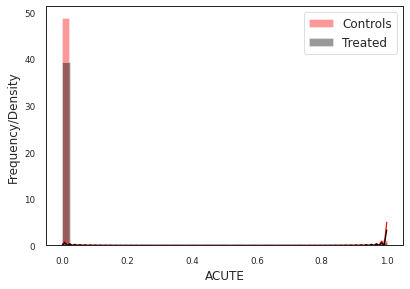

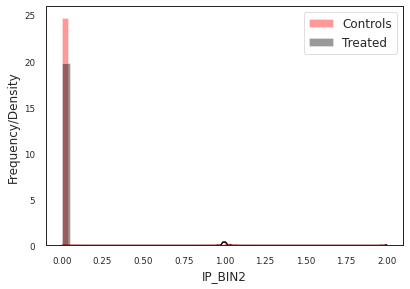

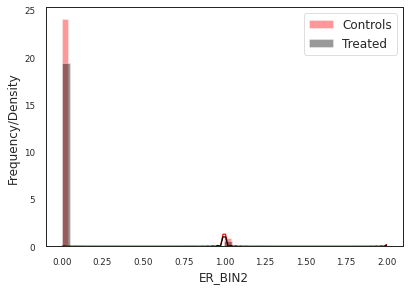

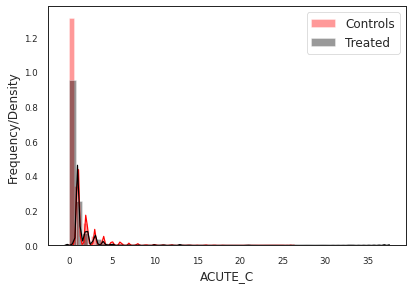

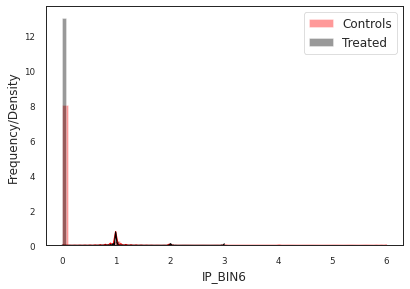

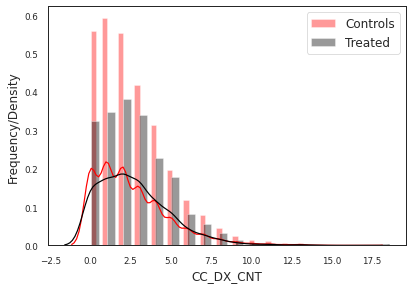

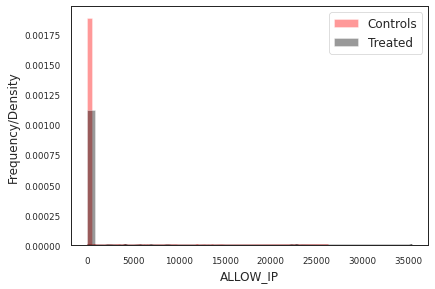

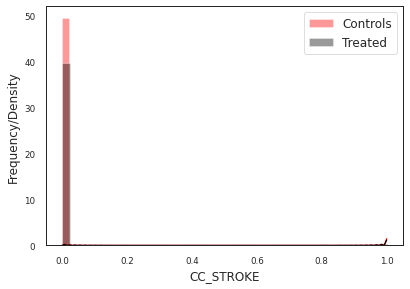

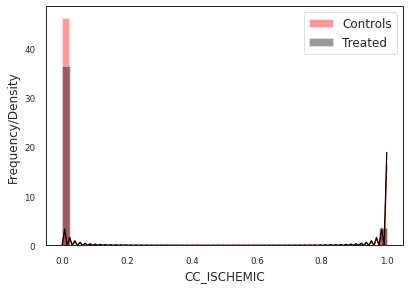

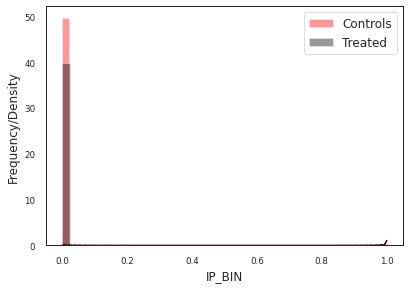

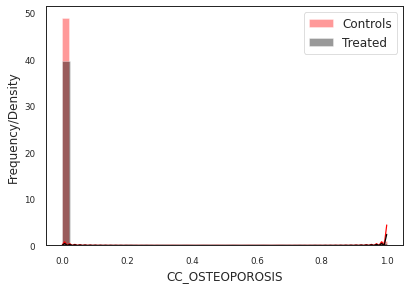

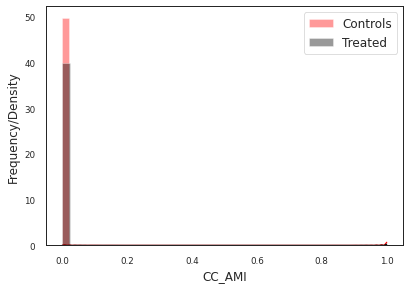

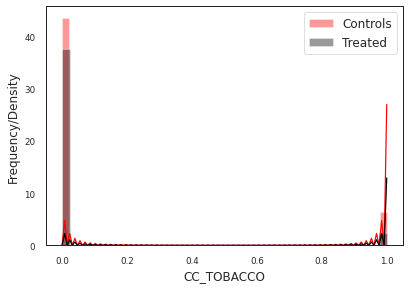

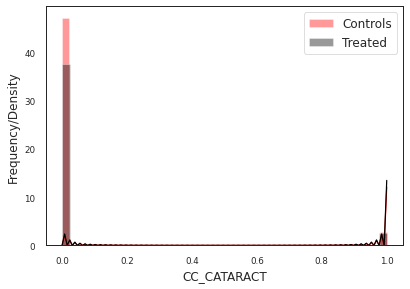

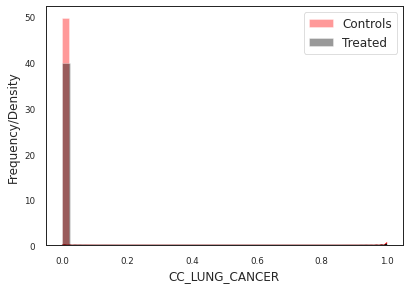

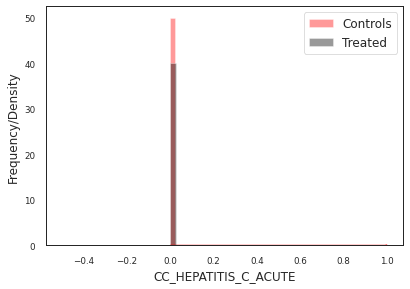

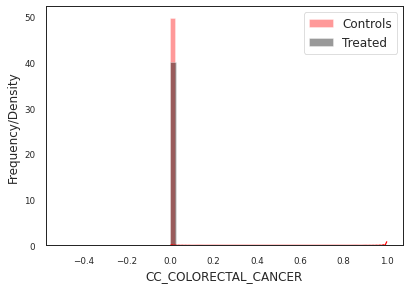

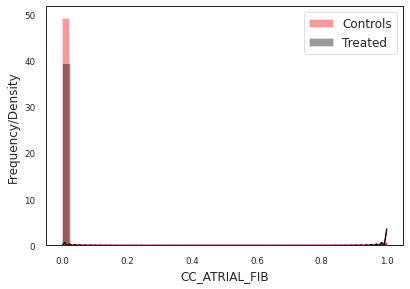

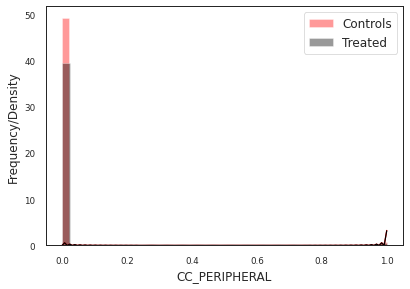

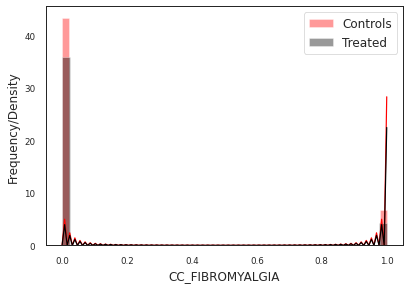

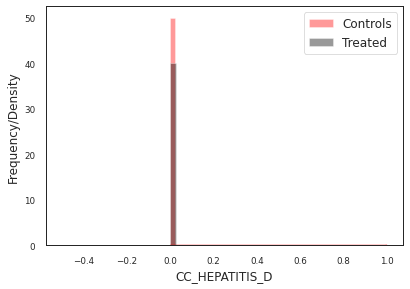

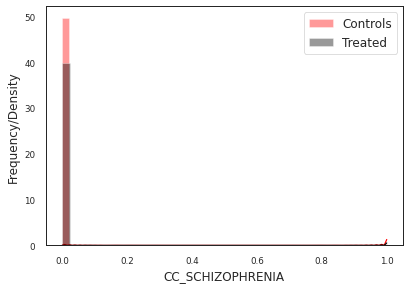

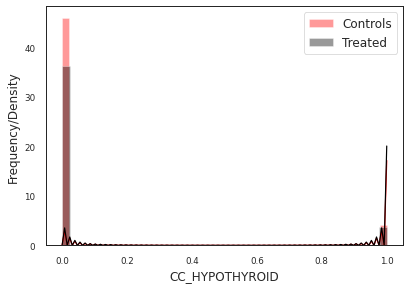

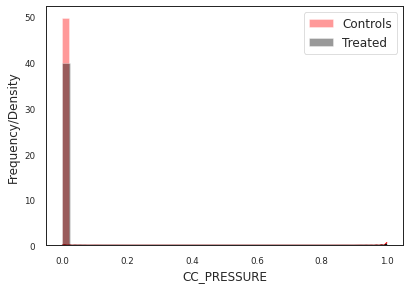

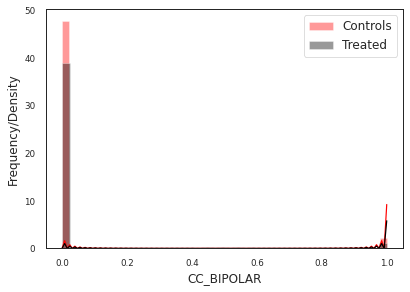

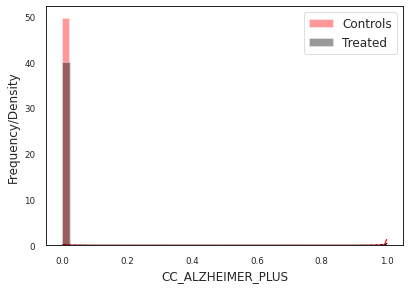

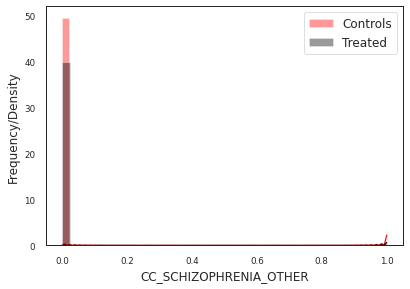

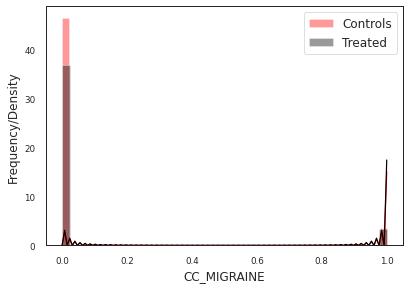

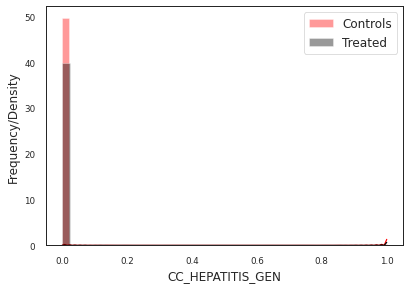

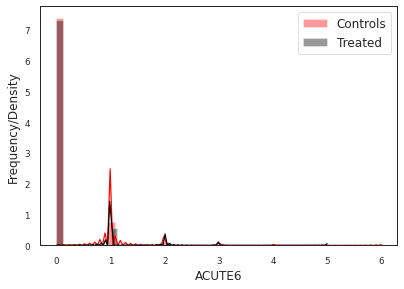

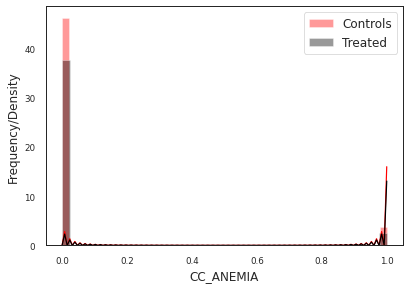

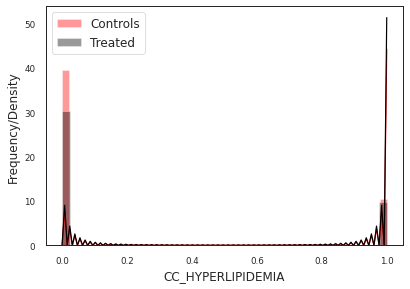

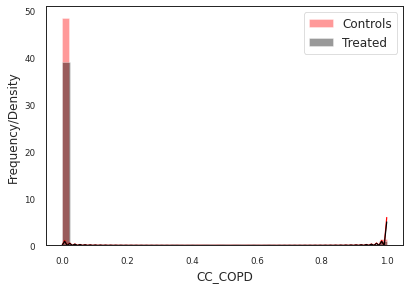

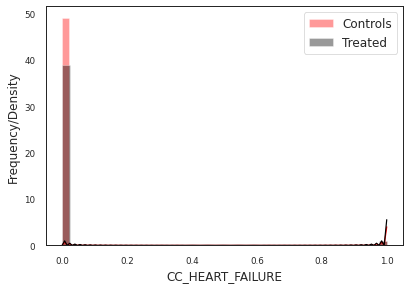

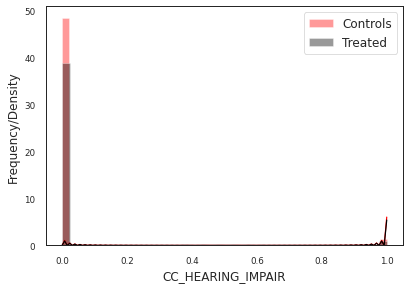

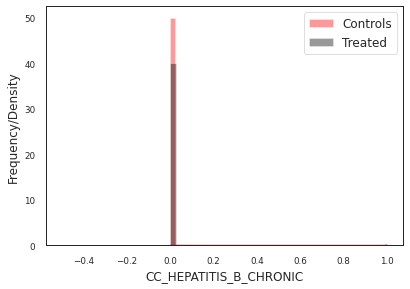

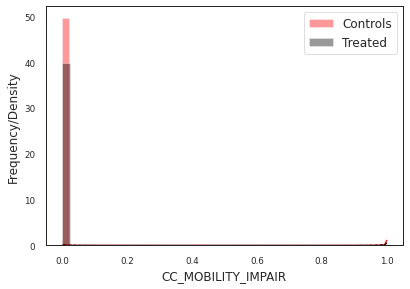

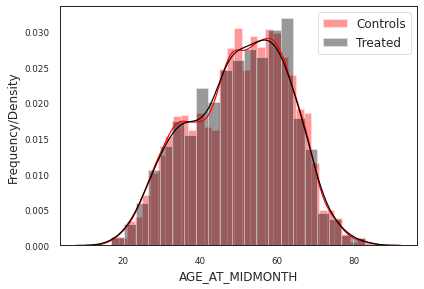

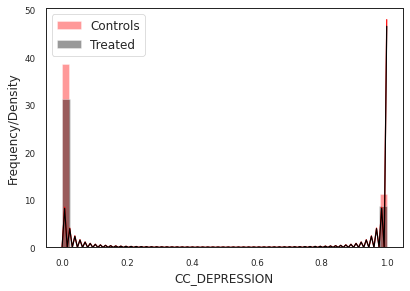

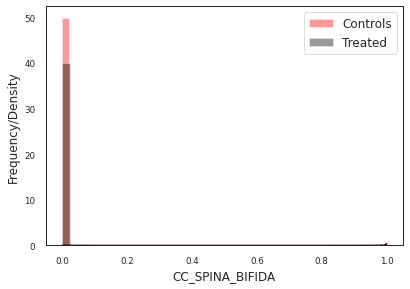

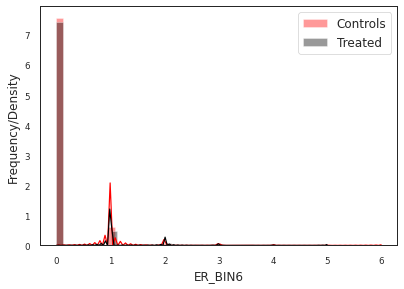

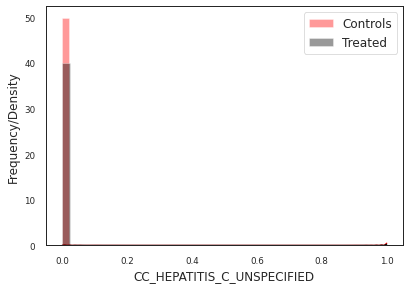

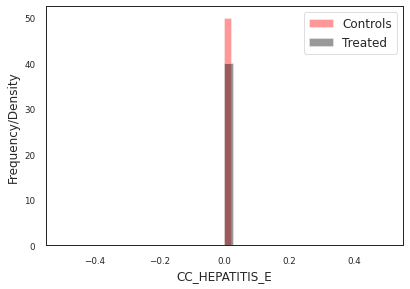

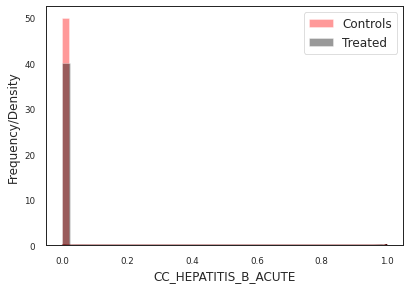

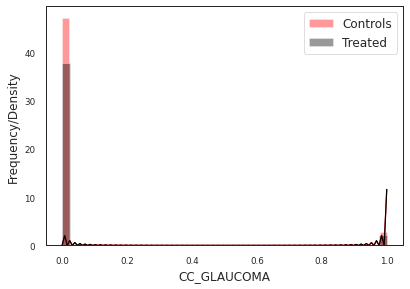

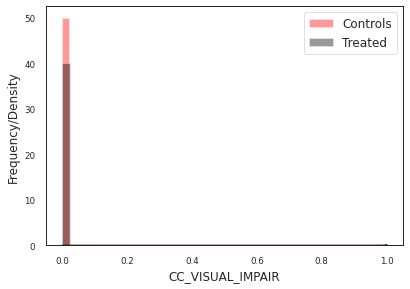

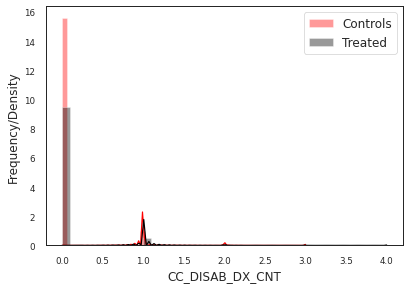

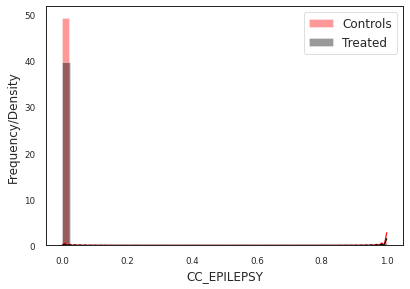

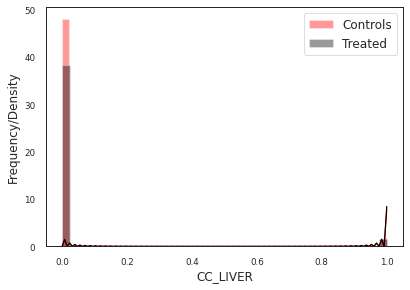

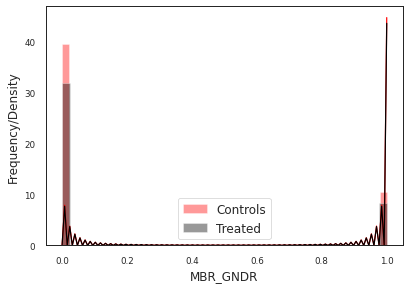

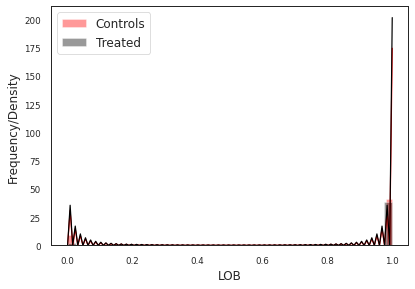

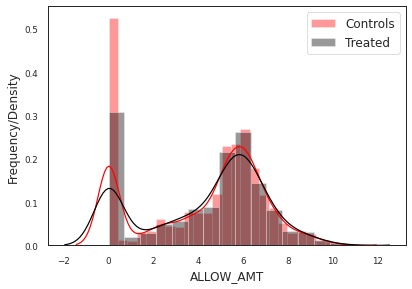

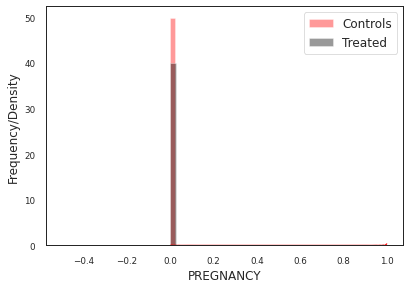

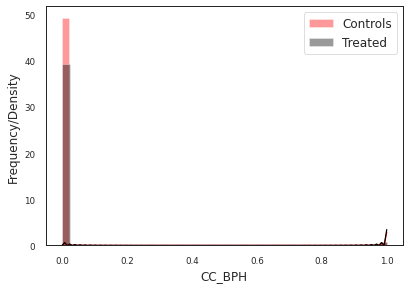

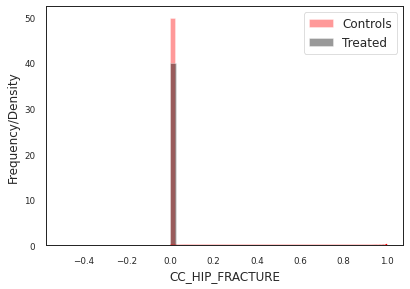

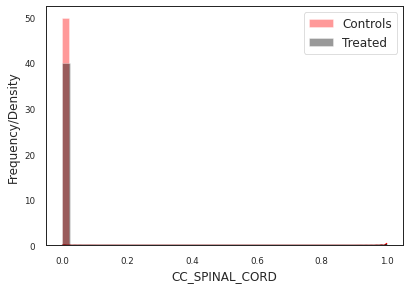

In [47]:
#%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

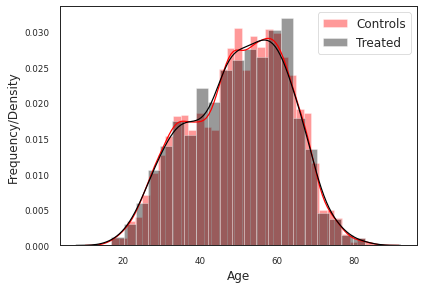

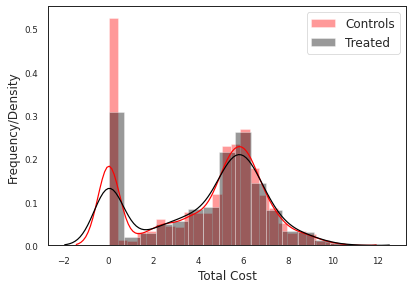

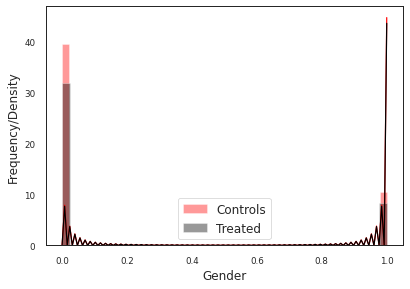

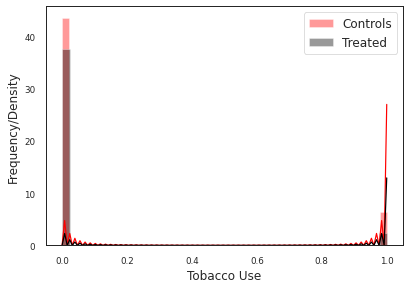

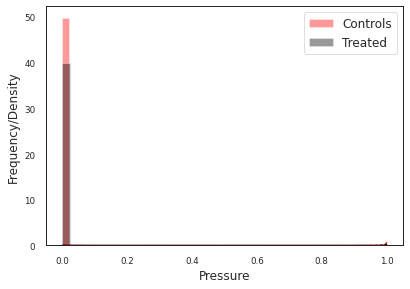

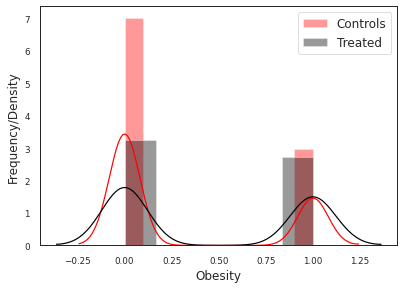

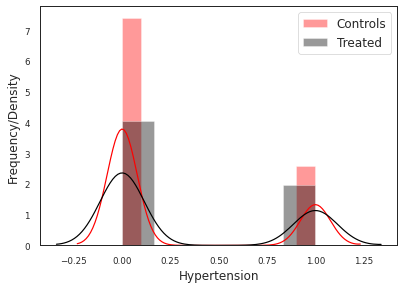

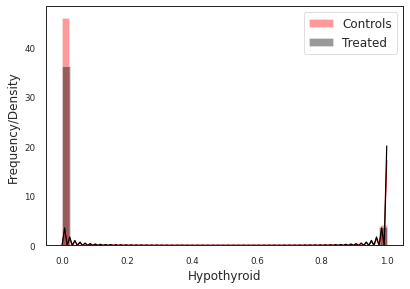

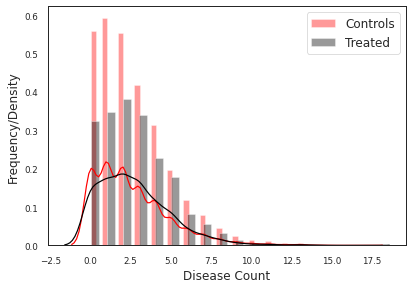

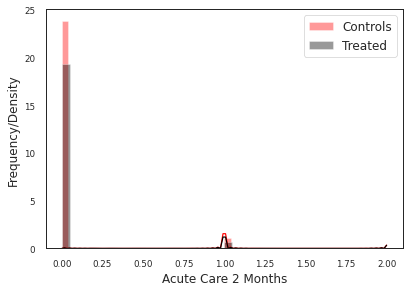

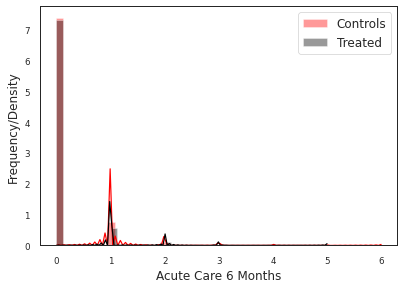

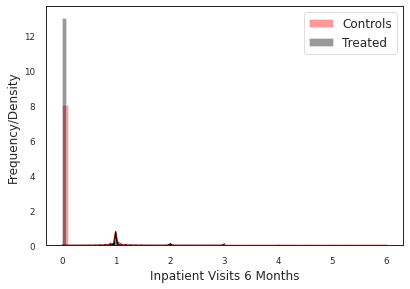

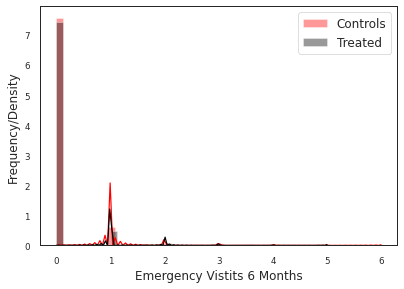

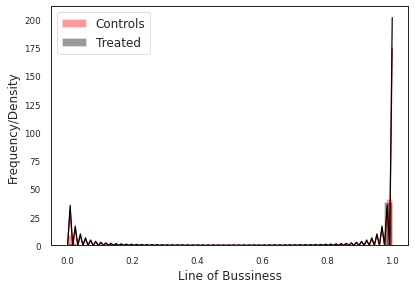

In [48]:
#%%capture
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

# Latent Space Stat

In [57]:
latent_cols

['x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16']

In [58]:
%%time
tr_desc0, treated_first_month = statistics_first_month(tr2, latent_cols, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_data0, latent_cols, return_array = True)

CPU times: user 2.6 s, sys: 0 ns, total: 2.6 s
Wall time: 2.6 s


In [55]:
pmpm_lat = data_process.transform_features_with_NN(model, pmpm[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)

In [59]:
%%time
pmpm_desc = statistics_first_month(pmpm_lat, latent_cols)
random_desc = statistics_first_month(rndm, latent_cols)

CPU times: user 1min 44s, sys: 1.14 s, total: 1min 45s
Wall time: 1min 45s


In [60]:
%%time
conds_first_latent, full_first_latent = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = latent_cols)
#conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)

CPU times: user 14 ms, sys: 748 µs, total: 14.8 ms
Wall time: 14 ms


In [61]:
conds_first_latent

Treated Matched Controls   Test-TC           General Population     Random
          mean             mean    t-stat      pval               mean       mean
x1  -23.822917       -23.503219 -0.155292  0.876595         -44.713254 -26.118523
x2   23.744400        23.429656  0.155058  0.876779          44.380419  26.021895
x3  -24.649667       -24.322183 -0.155125  0.876726         -46.094808 -27.007852
x4  -19.063797       -18.839028 -0.129594  0.896891         -38.999364 -21.838662
x5   11.947792        11.852477  0.076926  0.938684          29.105553  15.053039
x6  -15.680181       -15.516846 -0.109671  0.912673         -34.225559 -18.605027
x7  -25.775903       -25.433665 -0.153862  0.877722         -48.506657 -28.325218
x8  -22.487424       -22.188060 -0.155574  0.876372         -42.046000 -24.614238
x9   23.740579        23.423868  0.154904  0.876900          44.506736  26.041410
x10  26.027095        25.682728  0.154197  0.877458          48.783001  28.560991
x11 -20.068558       -19.832563 -0.131361  0.895493         -40.577726 -22.891081
x12  20.356972        20.111616  0.134401  0.893089          40.907011  23.077863
x13 -22.577532       -22.275773 -0.154876  0.876922         -42.376687 -24.770448
x14  22.009919        21.715554  0.154484  0.877231          41.421171  24.171772
x15  22.169132        21.881231  0.154066  0.877561          41.307775  24.296895
x16 -24.992617       -24.658409 -0.155169  0.876692         -46.848090 -27.394448

In [62]:
full_first_latent

Treated                  Matched Controls                    Test-TC           General Population                       Test-TG               Random                     Test-TR          
          mean        std count             mean        std count    t-stat      pval               mean         std   count    t-stat      pval       mean         std count    t-stat      pval
x1  -23.822917  78.741435  1604       -23.503219  74.217653  7710 -0.155292  0.876595         -44.713254  250.282663  356446  3.342101  0.000832 -26.118523  113.359993  7876  0.773888  0.439016
x2   23.744400  77.639239  1604        23.429656  73.177467  7710  0.155058  0.876779          44.380419  246.793986  356446 -3.348084  0.000814  26.021895  111.779426  7876 -0.778643  0.436209
x3  -24.649667  80.744297  1604       -24.322183  76.107163  7710 -0.155125  0.876726         -46.094808  256.635304  356446  3.345935  0.000820 -27.007852  116.243222  7876  0.775266  0.438202
x4  -19.063797  66.124635  1604       -18.839028  62.574108  7710 -0.129594  0.896891         -38.999364  208.080278  356446  3.836195  0.000125 -21.838662   94.962953  7876  1.116433  0.264265
x5   11.947792  46.857548  1604        11.852477  44.785073  7710  0.076926  0.938684          29.105553  142.298690  356446 -4.827868  0.000001  15.053039   66.874818  7876 -1.773104  0.076244
x6  -15.680181  56.618653  1604       -15.516846  53.766995  7710 -0.109671  0.912673         -34.225559  176.229431  356446  4.213646  0.000025 -18.605027   81.141083  7876  1.376973  0.168553
x7  -25.775903  85.058176  1604       -25.433665  80.192493  7710 -0.153862  0.877722         -48.506657  270.226762  356446  3.368141  0.000757 -28.325218  122.432447  7876  0.795721  0.426214
x8  -22.487424  73.617696  1604       -22.188060  69.366920  7710 -0.155574  0.876372         -42.046000  234.124794  356446  3.344990  0.000823 -24.614238  106.021260  7876  0.766639  0.443315
x9   23.740579  78.190815  1604        23.423868  73.710571  7710  0.154904  0.876900          44.506736  248.462865  356446 -3.346567  0.000818  26.041410  112.550596  7876 -0.781217  0.434694
x10  26.027095  85.398678  1604        25.682728  80.516634  7710  0.154197  0.877458          48.783001  271.269897  356446 -3.358902  0.000783  28.560991  122.908022  7876 -0.787839  0.430810
x11 -20.068558  68.512649  1604       -19.832563  64.811261  7710 -0.131361  0.895493         -40.577726  215.836017  356446  3.804760  0.000142 -22.891081   98.426641  7876  1.095679  0.273247
x12  20.356972  69.644810  1604        20.111616  65.852305  7710  0.134401  0.893089          40.907011  219.542726  356446 -3.747977  0.000178  23.077863  100.056730  7876 -1.039022  0.298821
x13 -22.577532  74.513002  1604       -22.275773  70.242901  7710 -0.154876  0.876922         -42.376687  236.770452  356446  3.348297  0.000813 -24.770448  107.255931  7876  0.781331  0.434627
x14  22.009919  72.873278  1604        21.715554  68.695561  7710  0.154484  0.877231          41.421171  231.592870  356446 -3.356087  0.000791  24.171772  104.907456  7876 -0.787515  0.431000
x15  22.169132  71.477338  1604        21.881231  67.367451  7710  0.154066  0.877561          41.307775  227.199104  356446 -3.372947  0.000744  24.296895  102.919305  7876 -0.790084  0.429498
x16 -24.992617  82.375762  1604       -24.658409  77.648819  7710 -0.155169  0.876692         -46.848090  261.786025  356446  3.342864  0.000829 -27.394448  118.580028  7876  0.774047  0.438922

In [63]:
conds_first_latent.to_csv('./results/hier_matching_ALL/tables/stats/conds_first_latent.csv', index=True, header=True)

In [64]:
full_first_latent.to_csv('./results/hier_matching_ALL/tables/stats/full_first_latent.csv', index=True, header=True)

### Save enhanced stats arrays(these will be used at the end)
Arrays with: Statistics in first day, statistics  in the span of monthsm statistiocs from selected columns and all columns

In [49]:
arrays = [conds_first, full_first, conds_firstAllCols, full_firstAllCols,
         conds, full, conds_AllCols, full_AllCols]
names = ['conds_first', 'full_first', 'conds_firstAllCols', 'full_firstAllCols',
         'conds', 'full', 'conds_AllCols', 'full_AllCols']
save_arrays2(arrays, names, base_path+'tables/stats/')